<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/machine_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision using pre trained models

## Read licence number of a car

License plate recognition systems can be found every day on highways, in underground garages, etc. The following solution uses a ready-made character recognition (OCR) procedure. The basic condition for this is that we can separate the part containing the text from the rest of the image. Thus, our solution can be divided into two parts. We first look for the convex rectangular shapes in the image, and then we try to recognize the possible text within it.

We'll use OpenCV and Google tesseract (neural network solution).

In [ ]:
# install google tesseract
!sudo apt -qq install tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
!pip install -q pytesseract

The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Selecting prev

In [ ]:
import requests
import imutils
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract

In [ ]:
# download sample image
!wget -q -O sample_data/plate1.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/plate1.png

It is assumed that the license plate is surrounded by a frame that contrasts with the other parts.

The next function search for the rectangular borders in the image, then it call google tesseract to recognise the text in the found rectangular areas. The function draw also the steps of the solution.

In [ ]:
def plate(gray, thres1, thres2):
  """ search for framed text in the image """
  orig = gray.copy()
  edged = cv2.Canny(gray, thres1, thres2) # edge detection
  # search for closed areas, keep larger ones
  cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10] # first ten areas by size
  for c in cnts:
    # smooth outline
    peri = cv2.arcLength(c, True)
    screenCnt = cv2.approxPolyDP(c, 0.018 * peri, True)
    a1 = cv2.contourArea(screenCnt)
    a2 = cv2.contourArea(cv2.convexHull(screenCnt))
    if len(screenCnt) == 4 and 0.9 < a1 / a2 < 1.1:    # outline has four corners and convex?
      # mask for plate
      mask = np.zeros(gray.shape, np.uint8)            # fill with black
      cv2.drawContours(mask, [screenCnt], 0, 255, -1)  # filled outline added to mask
      (x, y) = np.where(mask == 255)                   # white pixels
      (topx, topy) = (np.min(x), np.min(y))            # boundary rectangle
      (bottomx, bottomy) = (np.max(x), np.max(y))
      cropped = gray[topx:bottomx+1, topy:bottomy+1]   # cut from the image
      text = pytesseract.image_to_string(cropped, config='--psm 11')   # read plate number
      text = text.strip('\n\r\f')                      # trim EOL characters
      if len(text) > 0:
        print(topx, topy, bottomx, bottomy, text)
        cv2.polylines(orig, [screenCnt], True, 255, 10) # draw outline
  fig, ax = plt.subplots(1, 3, figsize=(15, 4))
  ax[0].imshow(gray, cmap='gray')
  ax[0].set_title('smoothed image')
  ax[1].imshow(edged, cmap='gray')
  ax[1].set_title('edge detection')
  ax[2].imshow(orig, cmap='gray')
  ax[2].set_title('found texts')

341 315 434 694 NLE-003
341 315 434 695 NLE-003


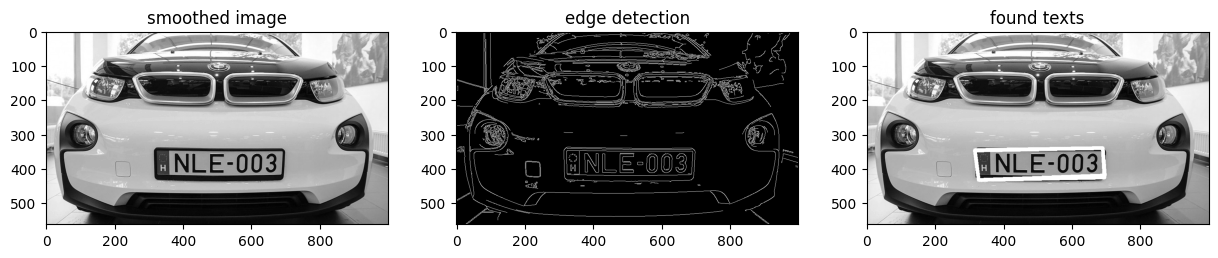

In [ ]:
gray = cv2.imread('sample_data/plate1.png', cv2.IMREAD_GRAYSCALE)
plate(gray, 100, 255)

334 455 393 706 SNGG XMZ |
335 455 390 706 -SN66 XMZ |


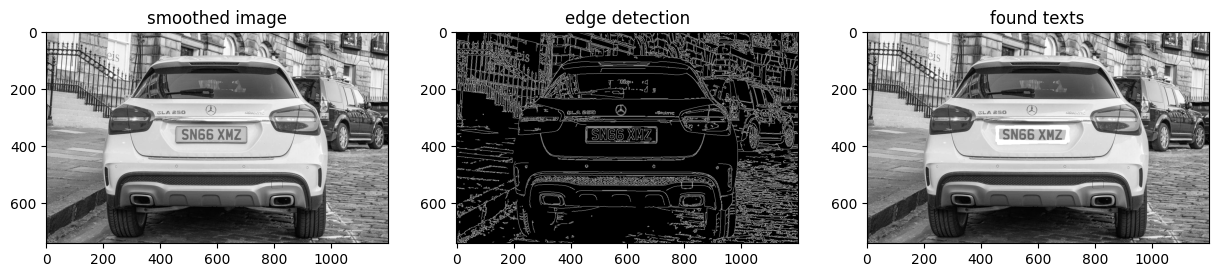

In [ ]:
!wget -q -O sample_data/plate2.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/plate2.png
gray1 = cv2.imread('sample_data/plate2.png', cv2.IMREAD_GRAYSCALE)
plate(gray1, 100, 250)

## Image classification

Using artificial intelligence, deep learning and convolutional neural networks, better and better models are developed to classify images. Thre are several models that are freely available.

We will use a DenseNet-Caffe model (Densely Connected Convolutional Networks - https://arxiv.org/abs/1608.06993) from ImageNet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012).



In [ ]:
import PIL
print(PIL.__version__)
if not PIL.__version__.startswith('9.'):
    print('PIL version is too old. Have you restarted Runtime environment?')


9.4.0


First let's download the trained model.

In [ ]:
!wget -q -O sample_data/classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/classification_classes_ILSVRC2012.txt
!wget -q -O sample_data/DenseNet_121.caffemodel https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/DenseNet_121.caffemodel
!wget -q -O sample_data/DenseNet_121.prototxt https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/DenseNet_121.prototxt

Let's load the downloaded model.

In [ ]:
# ImageNet class names
with open('sample_data/classification_classes_ILSVRC2012.txt', 'r') as f:
   class_names = f.read().split('\n')
model = cv2.dnn.readNet(model='sample_data/DenseNet_121.caffemodel',
                        config='sample_data/DenseNet_121.prototxt',
                        framework='Caffe')

We create a function to use the model for an image. During the pre-processing image is scaled down and mean is sustracted.

In [ ]:
def classify_img(image):
    """ find object on image """
    # create blob from image
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=0.01, size=(224, 224),
                                 mean=(104, 117, 123))
    model.setInput(blob)        # set the input blob for the neural network

    outputs = model.forward()   # forward pass image blog through the model
    final_outputs = outputs[0]
    final_outputs = final_outputs.reshape(1000, 1)  # make all the outputs 1D

    label_id = np.argmax(final_outputs) # get the class label
    # convert the output scores to softmax probabilities
    probs = np.exp(final_outputs) / np.sum(np.exp(final_outputs))
    final_prob = np.max(probs) * 100.   # get the final highest probability
    # map the max confidence to the class label names
    out_name = class_names[label_id]
    out_text = f"{out_name}, {final_prob:.1f} %"
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(out_text)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [ ]:
!wget -q -O sample_data/sh1.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/sh1.jpg

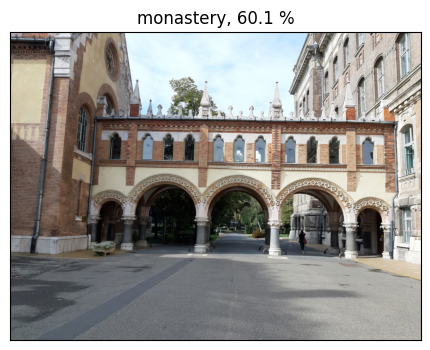

In [ ]:
img1 = cv2.imread('sample_data/sh1.jpg')
classify_img(img1)

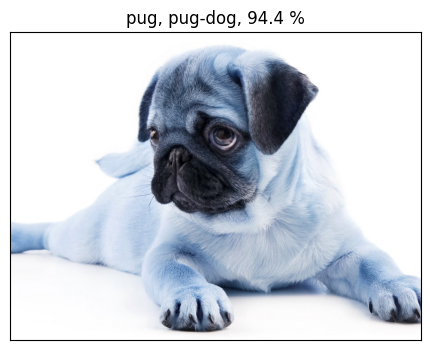

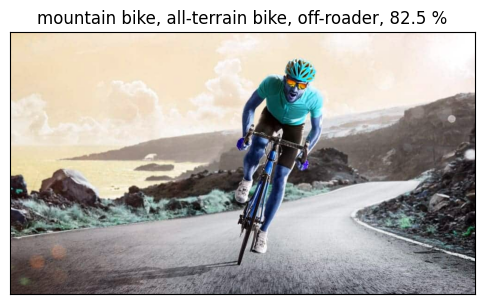

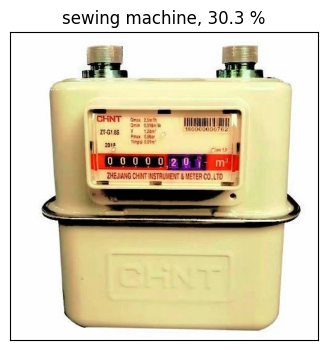

In [ ]:
urls = ['https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d',
        'https://lemonbin.com/wp-content/uploads/2020/06/cyclist-june172020-min.jpg',
        'https://5.imimg.com/data5/TestImages/LC/LC/YS/SELLER-18789923/domestic-diaphragm-type-gas-meter-500x500.jpg']
for url in urls:
    im = np.array(PIL.Image.open(requests.get(url, stream=True).raw))
    classify_img(im)

## CIFAR-10 sample dataset

CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class (https://www.cs.toronto.edu/~kriz/cifar.html). First we create a CNN model using Keras.

**Note**
Please turn on the GPU in your Colab the GPU. **Edit/Notebook settings** from the menu and select T4 GPU. The output of the next code block should be *Tesla T4*.

In [ ]:
!nvidia-smi -q -i 0 | grep "Product Name"

    Product Name                          : Tesla T4


In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

Create and train the modell. It'll take 4-5 minutes approximately.

> Indented block



In [ ]:
%%time
# Load data set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data set to 0-to-1 range
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Create a model and add layers
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# Train the model
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True
)

Epoch 1/30
782/782 [==============================] - 9s 9ms/step - loss: 1.5198 - accuracy: 0.4477 - val_loss: 1.1633 - val_accuracy: 0.5825
Epoch 2/30
782/782 [==============================] - 7s 9ms/step - loss: 1.1246 - accuracy: 0.5969 - val_loss: 0.9925 - val_accuracy: 0.6440
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9714 - accuracy: 0.6575 - val_loss: 0.8639 - val_accuracy: 0.6993
Epoch 4/30
782/782 [==============================] - 6s 8ms/step - loss: 0.8766 - accuracy: 0.6900 - val_loss: 0.7855 - val_accuracy: 0.7312
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.7974 - accuracy: 0.7184 - val_loss: 0.7454 - val_accuracy: 0.7409
Epoch 6/30
782/782 [==============================] - 9s 12ms/step - loss: 0.7503 - accuracy: 0.7367 - val_loss: 0.7062 - val_accuracy: 0.7561
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.7058 - accuracy: 0.7510 - val_loss: 0.7490 - val_accuracy: 0.7433
Epoch

In [ ]:
score, acc = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# Save neural network structure
model_structure = model.to_json()
f = Path("cifar-10_model_structure.json")
f.write_text(model_structure)
# Save neural network's trained weights
model.save_weights("cifar-10_model.weights.h5")

Loading the model

In [ ]:
f = Path("cifar-10_model_structure.json")
model_structure = f.read_text()
# Recreate the Keras model object from the json data
model = model_from_json(model_structure)
# Load the model's trained weights
model.load_weights("cifar-10_model.weights.h5")

Let's try the trained model for new images

In [ ]:
images = ['https://www.shutterstock.com/image-photo/forg-260nw-151350374.jpg'] # TODO

Load images and put together in a 4D numpy array

In [ ]:
np_images = np.zeros((len(images), 32, 32, 3))
for i, img_name in enumerate(images):
    # Load and resize to 32x32 pixels (as required by this model)
    img = np.array(PIL.Image.open(requests.get(namw, stream=True).resize.raw))
    #img = image.load_img(img_name, target_size=(32, 32))
    # Convert the image to a numpy array
    np_images[i] = image.img_to_array(img)

FileNotFoundError: [Errno 2] No such file or directory: 'https://www.shutterstock.com/image-photo/forg-260nw-151350374.jpg'

Making prediction from the model

In [ ]:
results = model.predict(np_images)

Output results

In [ ]:
class_labels = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
j = 0
for single_result in results:
    likely_class_indices = np.argsort(single_result)[::-1]  # sort & reverse
    for i in likely_class_indices:
        if single_result[likely_class_indices[i]] > 0.099999:
            print(f"{images[j]} image is a {class_labels[i]} - Likelihood: {single_result[likely_class_indices[i]]:.2%}")
    j += 1

# Object detection with YOLO

In [21]:
%cd
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

/root
fatal: destination path 'yolov5' already exists and is not an empty directory.
/root/yolov5


In [31]:
import glob
import cv2
from matplotlib import pyplot as plt
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/78.2 GB disk)


In [32]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/2 /root/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 58.6ms
image 2/2 /root/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 58.3ms
Speed: 0.5ms pre-process, 58.5ms inference, 269.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


['runs/detect/exp/bus.jpg']


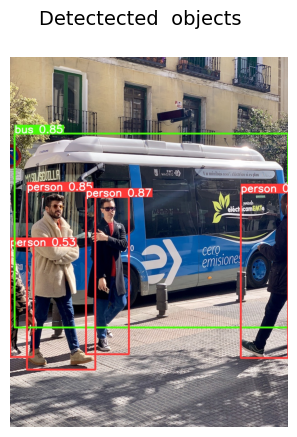

In [35]:
# get images with detected objects and show them
im_list = glob.glob('runs/detect/exp/*')
print(im_list)
n = len(im_list)
fig, axes = plt.subplots(n)
fig.suptitle('Detectected  objects', fontsize=14)
for i in range(n):
    im = cv2.imread(im_list[i])
    plt.imshow( cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    axes.axis('off')

In [30]:
im_list

['runs/detect/exp/bus.jpg']